<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/Integration_and_test(one_sample_forward_test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import joblib
import os
import numpy as np
import pandas as pd
!pip install autorch > log.txt
import matplotlib.pyplot as plt
import autorch
from autorch.function import sp2wt
import random
random.seed(11)
np.random.seed(11)

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Predict Class

In [103]:
class Predict(object):
  def __init__(self):
#==============================================================================================================    
    # icg
    self.model_icg = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_icg.pkl')
    self.icg_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_c670.csv',index_col=0).dropna(axis=0)
    self.icg_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_c670.pkl')

    # c620
    self.c620_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0).dropna(axis=0)
    self.c620_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_mbcheck.csv',index_col=0).dropna(axis=0)
    self.model_c620_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
    self.model_c620_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620.pkl')
    self.c620_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl') 
    
    # c660
    self.c660_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0).dropna(axis=0)
    self.c660_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_mbcheck.csv',index_col=0).dropna(axis=0)
    self.model_c660_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
    self.model_c660_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660.pkl')
    self.c660_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')

    # c670
    self.c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train.csv',index_col=0).dropna(axis=0)
    self.c670_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_mbcheck.csv',index_col=0).dropna(axis=0)
    self.model_c670_sf = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')
    self.model_c670_op = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')
    self.c670_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c670_col_names.pkl')
    
    #t651
    self.t651_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/t651_train.csv',index_col=0).dropna(axis=0)
    self.t651_col_names = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/t651_col_names.pkl')
#==============================================================================================================
# Load ICG input
  def load_icg_input(self):
    return self.icg_df[self.model_icg.x_col]

# Predict ICG
  def icg_dist(self,icg_input):
    while True:
      output = self.model_icg.predict(icg_input)
      if np.allclose(output['Simulation Case Conditions_C620 Distillate Rate_m3/hr'].values[0],0.01,atol=1e-2):
        print('current Distillate Rate is:{} so NA in Benzene_ppmw -= 30'.format(output['Simulation Case Conditions_C620 Distillate Rate_m3/hr'].values[0]))
        icg_input['Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw'] -= 30
      else:
        return output
#==============================================================================================================  
  # Load c620 input
  def load_c620(self,icg_dist):
    c620_x = self.c620_df[self.model_c620_sf.x_col]
    c620_x.filter(regex='Distillate Rate')[:] = icg_dist.values
    return c620_x
    
  # Predict c620 WT
  def c620_wt(self,c620_x):
    idx = c620_x.index
    c620_sf = self.model_c620_sf.predict(c620_x).iloc[:,:41*4]
    x41 = c620_x[self.c620_col_names['x41']].values
    s1 = c620_sf[self.c620_col_names['vent_gas_sf']].values
    s2 = c620_sf[self.c620_col_names['distillate_sf']].values
    s3 = c620_sf[self.c620_col_names['sidedraw_sf']].values
    s4 = c620_sf[self.c620_col_names['bottoms_sf']].values
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    w3 = sp2wt(x41,s3)
    w4 = sp2wt(x41,s4)
    c620_wt = np.hstack((w1,w2,w3,w4))
    c620_wt = pd.DataFrame(
        c620_wt,
        index = idx,
        columns = 
        self.c620_col_names['vent_gas_x']+\
        self.c620_col_names['distillate_x']+\
        self.c620_col_names['sidedraw_x']+\
        self.c620_col_names['bottoms_x'])
    return c620_wt

  # Predict c620 OP
  def c620_op(self,c620_x):
    return self.model_c620_op.predict(c620_x).iloc[:,41*4:] 
#============================================================================================================== 
  # Load c660 input
  def load_c660(self,c620_w3):
    idx = c620_w3.index
    feed_t651 = self.t651_df.loc[idx,self.t651_col_names['x41']]
    t651_mf = self.t651_df.loc[idx,self.t651_col_names['MFR']]
    c620_mf = self.c620_mb.loc[idx,['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Mass Flow Rate_ton/hr']]
    total = t651_mf.values + c620_mf.values
    t651_mf = t651_mf/total
    c620_mf = c620_mf/total
    c660_feed = c620_w3.values*c620_mf.values.reshape(-1,1) + feed_t651.values*t651_mf.values.reshape(-1,1)
    c660_feed = pd.DataFrame(c660_feed,index=idx,columns=self.c660_col_names['x41'])
    c660_case = self.c660_df.loc[idx,self.c660_col_names['case']]
    return c660_case.join(c660_feed)
    
  # Predict c660 WT
  def c660_wt(self,c660_x):
    idx = c660_x.index
    c660_sf = self.model_c660_sf.predict(c660_x[self.model_c660_sf.x_col]).iloc[:,:41*4]
    x41 = c660_x.loc[idx,self.c660_col_names['x41']]
    s1 = c660_sf[self.c660_col_names['vent_gas_sf']].values
    s2 = c660_sf[self.c660_col_names['distillate_sf']].values
    s3 = c660_sf[self.c660_col_names['sidedraw_sf']].values
    s4 = c660_sf[self.c660_col_names['bottoms_sf']].values
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    w3 = sp2wt(x41,s3)
    w4 = sp2wt(x41,s4)
    c660_wt = np.hstack((w1,w2,w3,w4))
    c660_wt = pd.DataFrame(
        c660_wt,
        index=idx,
        columns=
        self.c660_col_names['vent_gas_x']+\
        self.c660_col_names['distillate_x']+\
        self.c660_col_names['sidedraw_x']+\
        self.c660_col_names['bottoms_x'])
    return c660_wt
  
  # Predict c660 OP
  def c660_op(self,c660_x):
    return self.model_c660_op.predict(c660_x).iloc[:,41*4:]
#============================================================================================================== 
  # Load c670 input
  def load_c670(self,c620_w4,c660_w4):
    idx = c620_w4.index
    Tray_43_mfr = self.c670_mb.loc[idx,['Toluene Column C670 Operation_Feed Properties \n@ Tray 43_Mass Flow Rate_ton/hr']]
    Tray_54_mfr = self.c670_mb.loc[idx,['Toluene Column C670 Operation_Feed Properties \n@ Tray 54_Mass Flow Rate_ton/hr']]
    total = Tray_43_mfr.values + Tray_54_mfr.values
    Tray_43_mfr = Tray_43_mfr/total
    Tray_54_mfr = Tray_54_mfr/total
    combined = c660_w4.values*Tray_43_mfr.values.reshape(-1,1) + c620_w4.values*Tray_54_mfr.values.reshape(-1,1)
    combined = pd.DataFrame(combined,index=idx,columns=self.c670_col_names['combined'])
    upper_bf = self.c670_df.loc[idx,self.c670_col_names['upper_bf']]
    lower_bf = self.c670_df.loc[idx,self.c670_col_names['lower_bf']]
    c670_x = combined.join(upper_bf).join(lower_bf)
    return c670_x
  
  # Predict c670 WT
  def c670_wt(self,c670_x):
    idx = c670_x.index
    c670_sf = self.model_c670_sf.predict(c670_x).iloc[:,:41*4]
    x41 = c670_x.iloc[:,:41].values
    s1 = c670_sf[self.c670_col_names['distillate_sf']].values
    s2 = c670_sf[self.c670_col_names['bottoms_sf']].values
    w1 = sp2wt(x41,s1)
    w2 = sp2wt(x41,s2)
    c670_wt = np.hstack((w1,w2))
    c670_wt = pd.DataFrame(
        c670_wt,
        index = idx,
        columns=
        self.c670_col_names['distillate_x']+\
        self.c670_col_names['bottoms_x'])
    return c670_wt
  
  # Predict c670 OP
  def c670_op(self,c670_x):
    c670_op = self.model_c670_op.predict(c670_x).iloc[:,41*2:]
    return c670_op
#============================================================================================================== 

In [104]:
predict = Predict()

# get one sample

In [109]:
commom_idx = list(set(predict.icg_df.index)&\
                  set(predict.c620_df.index)&\
                  set(predict.c660_df.index)&\
                  set(predict.c670_df.index)&\
                  set(predict.t651_df.index))

commom_idx = np.random.choice(commom_idx, size=1,replace=False,p=None)

for key in dir(predict):
  if key.split('_')[1] in ['df','mb']:
    setattr(predict,key,getattr(predict,key).loc[commom_idx])

for key in dir(predict):
  if key.split('_')[1] in ['df','mb']:
    print(key,'num_samples:',len(getattr(predict,key)))

c620_df num_samples: 1
c620_mb num_samples: 1
c660_df num_samples: 1
c660_mb num_samples: 1
c670_df num_samples: 1
c670_mb num_samples: 1
icg_df num_samples: 1
t651_df num_samples: 1


# ICG

In [110]:
icg_x = predict.load_icg_input()
icg_x.head()

,Simulation Case Conditions_Feed Rate_Feed from V615 Btm_m3/hr,Simulation Case Conditions_Feed Rate_Feed from V615 Btm NA_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from V615 Btm Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist_m3/hr,Simulation Case Conditions_Feed Rate_Feed from C820 Dist NA_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from C820 Dist Toluene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651_m3/hr,Simulation Case Conditions_Feed Rate_Feed from T651 NA_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Benzene_wt%,Simulation Case Conditions_Feed Rate_Feed from T651 Toluene_wt%,Simulation Case Conditions_Spec 1 : Benzene in C620 Sidedraw_wt%,Simulation Case Conditions_Spec 2 : NA in Benzene_ppmw
066-002,188.0,1.356,10.321001,40.887009,15.0,2.338977,74.302254,17.467825,92.0,0.0911,20.854397,74.689774,90.0,980.0


In [111]:
icg_dist = predict.icg_dist(icg_x)
icg_dist

current Distillate Rate is:0.010000373236835003 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.010000945068895817 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.010002327151596546 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.010005575604736805 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.010012634098529816 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.01002910640090704 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.010066120885312557 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.010148153640329838 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.010313128121197224 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.010598608292639256 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.010984527878463268 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.011570844799280167 so NA in Benzene_ppmw -= 30
current Distillate Rate is:0.012256312184035778 so NA in Benzene_ppmw -= 30
current Disti

,Simulation Case Conditions_C620 Distillate Rate_m3/hr
066-002,0.022086


In [112]:
icg_dist_gt = predict.icg_df.loc[icg_dist.index,icg_dist.columns]
icg_dist_gt.head()

,Simulation Case Conditions_C620 Distillate Rate_m3/hr
066-002,0.01


In [113]:
predict.model_icg.show_metrics(icg_dist,icg_dist_gt,e=2e-2)

,R2,MSE,MAPE
Simulation Case Conditions_C620 Distillate Rate_m3/hr,NaN,0.000146066,54.722
AVG,NaN,0.000146066,54.722


# c620

In [114]:
#C620 Input
c620_x = predict.load_c620(icg_dist)
c620_x.head()

,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
066-002,0.01,90.000008,0.0,0.023129,0.5588,0.51157,0.149504,0.069948,0.014504,15.109019,0.006735,0.013524,0.0,0.010776,39.134426,0.007184,0.008456,0.008456,0.943895,7.359532,16.074078,6.580838,0.012273,0.005551,0.00232,0.006476,0.907587,0.475535,2.40913,0.267373,6.153274,0.0,0.982525,0.032381,0.000925,0.021279,0.831724,0.0,0.956621,0.245169,0.105469,0.0,0.0


In [115]:
c620_wt = predict.c620_wt(c620_x)
c620_wt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [116]:
c620_wt_gt = predict.c620_df.loc[c620_wt.index,c620_wt.columns]
c620_wt_gt.head()

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

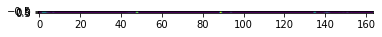

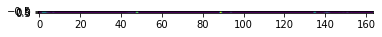

In [117]:
plt.imshow(c620_wt.head(41*4).values)
plt.show()
plt.imshow(c620_wt_gt.head(41*4).values)

In [118]:
predict.model_c620_sf.show_metrics(c620_wt,c620_wt_gt,e=2e-2)

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,NaN,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,NaN,7.5908e-05,0.531418
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,NaN,0.0486785,0.559762
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,NaN,0.0524141,0.640177
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,NaN,0.00732645,0.838032
...,...,...,...
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,NaN,2.16253e-08,0.049256
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,NaN,4.00089e-09,0.049249
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,NaN,0,NaN
Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,NaN,0,NaN


# check mass blance c620_wt

In [119]:
for i in range(4):
  assert np.allclose(c620_wt.iloc[:,41*i:41*(i+1)].sum(axis=1),100)
print('pass')

pass


In [120]:
input_mfr = predict.c620_mb.iloc[:,0].values.reshape(-1,1)
w1_mfr = predict.c620_mb.iloc[:,1].values.reshape(-1,1)
w2_mfr = predict.c620_mb.iloc[:,2].values.reshape(-1,1)
w3_mfr = predict.c620_mb.iloc[:,3].values.reshape(-1,1)
w4_mfr = predict.c620_mb.iloc[:,4].values.reshape(-1,1)
入料量 = (c620_x.iloc[:,-41:]*input_mfr).sum(axis=1).values
出料_w1 = (c620_wt.iloc[:,0:41]*w1_mfr).sum(axis=1).values
出料_w2 = (c620_wt.iloc[:,41:41*2]*w2_mfr).sum(axis=1).values
出料_w3 = (c620_wt.iloc[:,41*2:41*3]*w3_mfr).sum(axis=1).values
出料_w4 = (c620_wt.iloc[:,41*3:41*4]*w4_mfr).sum(axis=1).values
np.allclose(入料量,出料_w1+出料_w2+出料_w3+出料_w4)

True

#C620 OP

In [121]:
c620_op = predict.c620_op(c620_x)
c620_op.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
066-002,0.862153,0.452456,0.783487,0.881299,0.87188,131.684784,13.195435,15.340366,175.008286,193.60141


In [122]:
c620_op_gt = predict.c620_df.loc[c620_op.index,c620_op.columns]
c620_op_gt.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
066-002,0.862141,0.451215,0.779813,0.881317,0.871876,131.75383,13.169885,15.326366,174.959564,193.615448


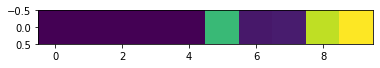

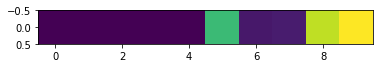

In [123]:
plt.imshow(c620_op.head(9).values)
plt.show()
plt.imshow(c620_op_gt.head(9).values)

In [124]:
predict.model_c620_op.show_metrics(c620_op,c620_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Feed Properties,NaN,1.36281e-10,0.00135404
Density_Vent Gas Production Rate and Composition,NaN,1.54146e-06,0.274403
Density_Distillate Production Rate and Composition,NaN,1.34964e-05,0.468896
Density_Sidedraw Production Rate and Composition,NaN,3.04256e-10,0.00197923
Density_Bottoms Production Rate and Composition,NaN,1.34657e-11,0.000420879
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,NaN,0.00476736,0.0524328
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,NaN,0.000652784,0.193625
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,NaN,0.000195998,0.0912621
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,NaN,0.00237377,0.0278394
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,NaN,0.000197068,0.00725103


#C660 WT

In [125]:
#C660 Input
c660_x = predict.load_c660(c620_wt[predict.c620_col_names['sidedraw_x']])
c660_x.head()

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw,Benzene Column C660 Operation_Specifications_Spec 3 : Toluene in Benzene_ppmw,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
066-002,980.000675,9.999991,0.0,0.000099,0.006439,0.012225,0.008175,0.010443,0.017584,39.022785,0.010471,0.017035,0.0,0.005794,57.608581,0.008301,0.007077,0.005822,1.455292,0.667377,1.027026,0.061141,0.01274,1.107434e-08,0.028204,1.942902e-09,5.522488e-07,2.057683e-07,1.659170e-07,9.091523e-08,1.021016e-07,0.002283,2.237865e-09,9.667732e-11,0.00405,0.001031,3.473292e-10,0.0,3.755338e-12,1.795892e-13,1.752867e-16,0.0,0.0


In [126]:
c660_wt = predict.c660_wt(c660_x)
c660_wt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [127]:
c660_wt_gt = predict.c660_df.loc[c660_wt.index,c660_wt.columns]
c660_wt_gt.head()

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

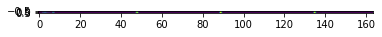

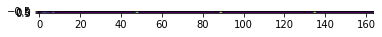

In [128]:
plt.imshow(c660_wt.head(41*4).values)
plt.show()
plt.imshow(c660_wt_gt.head(41*4).values)

In [129]:
predict.model_c660_sf.show_metrics(c660_wt,c660_wt_gt,e=2e-2)

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,NaN,0,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,NaN,7.4562e-05,2.84331
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,NaN,0.190311,2.4409
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,NaN,0.000206986,0.0527727
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,NaN,0.213289,4.34251
...,...,...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,NaN,1.39422e-28,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,NaN,1.32057e-34,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,NaN,0,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,NaN,0,NaN


# check mass blance c660_wt

In [130]:
for i in range(4):
  assert np.allclose(c660_wt.iloc[:,41*i:41*(i+1)].sum(axis=1),100)
print('pass')

pass


In [131]:
input_mfr = predict.c660_mb.iloc[:,0].values.reshape(-1,1)
w1_mfr = predict.c660_mb.iloc[:,1].values.reshape(-1,1)
w2_mfr = predict.c660_mb.iloc[:,2].values.reshape(-1,1)
w3_mfr = predict.c660_mb.iloc[:,3].values.reshape(-1,1)
w4_mfr = predict.c660_mb.iloc[:,4].values.reshape(-1,1)
入料量 = (c660_x.iloc[:,-41:]*input_mfr).sum(axis=1).values
出料_w1 = (c660_wt.iloc[:,0:41]*w1_mfr).sum(axis=1).values
出料_w2 = (c660_wt.iloc[:,41:41*2]*w2_mfr).sum(axis=1).values
出料_w3 = (c660_wt.iloc[:,41*2:41*3]*w3_mfr).sum(axis=1).values
出料_w4 = (c660_wt.iloc[:,41*3:41*4]*w4_mfr).sum(axis=1).values
np.allclose(入料量,出料_w1+出料_w2+出料_w3+出料_w4)

True

#C660 OP

In [132]:
c660_op = predict.c660_op(c660_x)
c660_op.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
066-002,0.875501,0.565773,0.856407,0.883693,0.870739,158.512253,15.074947,15.023908,86.814171,91.110748


In [133]:
c660_op_gt = predict.c660_df.loc[c660_op.index,c660_op.columns]
c660_op_gt.head()

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
066-002,0.875506,0.564492,0.857027,0.883691,0.870734,158.476028,15.078778,15.01852,86.812836,91.091125


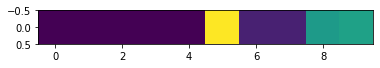

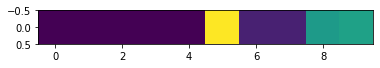

In [134]:
plt.imshow(c660_op.head(9).values)
plt.show()
plt.imshow(c660_op_gt.head(9).values)

In [135]:
predict.model_c660_op.show_metrics(c660_op,c660_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Feed Properties,NaN,3.49176e-11,0.000674941
Density_Vent Gas Production Rate and Composition,NaN,1.6404e-06,0.226377
Density_Distillate (Benzene Drag) Production Rate and Composition,NaN,3.8443e-07,0.0723982
Density_Sidedraw (Benzene )Production Rate and Composition,NaN,3.34078e-12,0.000206834
Density_Bottoms Production Rate and Composition,NaN,2.13238e-11,0.000530328
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,NaN,0.00131221,0.0228527
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,NaN,1.46704e-05,0.0254077
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,NaN,2.90231e-05,0.0358583
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,NaN,1.78262e-06,0.00153794
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,NaN,0.000385054,0.0215373


# C670 WT

In [136]:
#C670 Input
c620_w4,c660_w4 = c620_wt[predict.c620_col_names['bottoms_x']],c660_wt[predict.c660_col_names['bottoms_x']]
c670_x = predict.load_c670(c620_w4,c660_w4)
c670_x.head()

,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Hydrogen_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Propane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Butane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Pentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Hexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Benzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Heptane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Water_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Toluene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Octane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_p-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_m-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_o-Xylene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Nonane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_Indane_wt%,Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Combined Feed to Toluene Column C670 : Detailed weight % Composition_1,2-Diethylbenzene_wt%",Tol

In [137]:
c670_wt = predict.c670_wt(c670_x)
c670_wt = c670_wt.dropna(axis=0)
c670_wt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [138]:
c670_wt_gt = predict.c670_df.loc[c670_wt.index,c670_wt.columns]
c670_wt_gt.head()

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

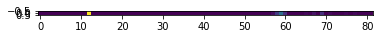

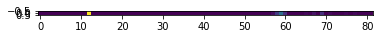

In [139]:
plt.imshow(c670_wt.head(41*2).values)
plt.show()
plt.imshow(c670_wt_gt.head(41*2).values)

In [140]:
predict.model_c670_sf.show_metrics(c670_wt,c670_wt_gt,e=2e-2)

,R2,MSE,MAPE
Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,NaN,0,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,NaN,4.03274e-14,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,NaN,1.83739e-11,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,NaN,2.27695e-11,NaN
Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,NaN,4.93631e-47,NaN
...,...,...,...
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,NaN,1.11668e-11,0.000632838
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,NaN,1.27017e-11,0.00156893
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,NaN,0,NaN
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,NaN,0,NaN


# check massblance c670_wt

In [141]:
for i in range(2):
  assert np.allclose(c670_wt.iloc[:,41*i:41*(i+1)].sum(axis=1),100)
print('pass')

pass


In [142]:
input_mfr = predict.c670_mb.iloc[:,[0,1]].sum(axis=1).values.reshape(-1,1)
w1_mfr = predict.c670_mb.iloc[:,2].values.reshape(-1,1)
w2_mfr = predict.c670_mb.iloc[:,3].values.reshape(-1,1)
入料量 = (c670_x.iloc[:,:41]*input_mfr).sum(axis=1).values
出料_w1 = (c670_wt.iloc[:,0:41]*w1_mfr).sum(axis=1).values
出料_w2 = (c670_wt.iloc[:,41:41*2]*w2_mfr).sum(axis=1).values
np.allclose(入料量,出料_w1+出料_w2)

True

#C670 OP

In [143]:
c670_op = predict.c670_op(c670_x)
c670_op.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
066-002,0.870949,0.872402,294.331146,34.696011,34.666317,181.577545,226.318924


In [144]:
c670_op_gt = predict.c670_df.loc[c670_op.index,c670_op.columns]
c670_op_gt.head()

,Density_Distillate Production Rate and Composition,Density_Bottoms Production Rate and Composition,Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC
066-002,0.870949,0.872415,292.448914,34.568528,34.542444,181.568665,226.345886


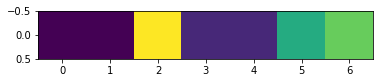

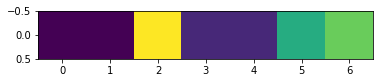

In [145]:
plt.imshow(c670_op.head(7).values)
plt.show()
plt.imshow(c670_op_gt.head(7).values)

In [146]:
predict.model_c670_op.show_metrics(c670_op,c670_op_gt,e=2e-2)

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,NaN,1.18531e-13,3.95297e-05
Density_Bottoms Production Rate and Composition,NaN,1.88704e-10,0.00157461
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,NaN,3.5428,0.639495
Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,NaN,0.0162517,0.367426
Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,NaN,0.0153444,0.357328
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,NaN,7.88645e-05,0.00489078
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,NaN,0.000726963,0.0119134
AVG,NaN,0.510743,0.197524
